# Flat Clustering with HDBSCAN

HDBSCAN produces a hierarchy, and selects a set of clusters from within this hierarchy based on cluster persistence (unless cluster_selection_method='leaf' is used). This clustering can be adjusted to have more or fewer clusters by adjusting some of the parameters as described in the documentation. One such parameter is 'cluster_selection_epsilon'. Setting cluster_selection_epsilon makes HDBSCAN ignore any cluster-splits that happen for distances smaller than this value.

In the current version of HDBSCAN, the effects of cluster_selection_epsilon are not fully integrated. Functions like approximate_predict, membership_vector, and all_points_membership_vectors do not take cluster_selection_epsilon into account.

A new module 'flat' is added to modify a few things here and there with the HDBSCAN class to propagate all cluster_selection_epsilon related changes. The benefits of this module are:
1. Flat clusterings can be easily extracted from the HDBSCAN hierarchy
2. The HDBSCAN class can be made to point to a particular flat clustering, so that later queries from methods such as approximate_predict produce this new choice of flat clustering.
3. Predictions using approximate_predict, membership_vector, and all_points_membership_vectors for any flat clustering (i.e., any number of clusters)

Some of these features are demonstrated in this notebook.

__Note__: The computations for the flat clusterings and predictions are not very efficient. Several variables are computed multiple times. The aim of the module is not to be efficient, but to provide a simple interface without modifying the core HDBSCAN code. In most cases, the extra computations should have a trivial cost.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from hdbscan import HDBSCAN
from hdbscan.flat import (HDBSCAN_flat,
                          approximate_predict_flat,
                          membership_vector_flat,
                          all_points_membership_vectors_flat)

/home/sabarish/envs/py37_dev/lib/python3.7/site-packages/pandas/compat/__init__.py:84: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# Create a simple dataset

We'll use a few circular clusters and a pair of moons for illustration.

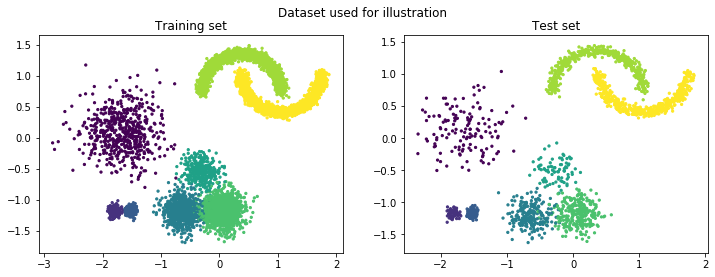

In [2]:
centers = [(0, 2), (-0.2, 0), (0.2, 0),
           (1.5, 0), (2., 1.), (2.5, 0.)]
std = [0.5, 0.08, 0.06, 0.25, 0.25, 0.25]
X, y = make_blobs(n_samples=[700, 300, 800, 1000, 400, 1500],
                  centers=centers,
                  cluster_std=std)
X1, y1 = make_moons(n_samples=5000, noise=0.07)
X1 += 3.
y1 += len(centers)
X = np.vstack((X, X1))
y = np.concatenate((y, y1))
scaler = StandardScaler()
X = scaler.fit_transform(X)
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2,
                                        random_state=42)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].set_title("Training set")
axes[0].scatter(X[:, 0], X[:, 1], c=y, s=5)
axes[1].set_title("Test set")
axes[1].scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=5)
plt.suptitle("Dataset used for illustration")
plt.show()

# Train HDBSCAN aimed at some flat clustering

The function used for this is hdbscan.flat.HDBSCAN_flat. Unlike hdbscan.HDBSCAN, this function directly takes the training set as the first positional argument. See docstring for details.

## Let HDBSCAN choose n_clusters

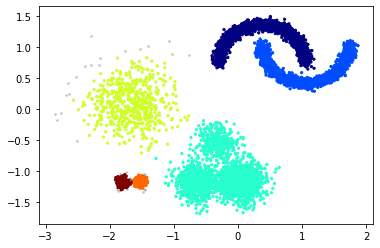

Unique labels (-1 for outliers): [-1  0  1  2  3  4  5]


In [3]:
clusterer = HDBSCAN_flat(X,
                         cluster_selection_method='eom',
                         n_clusters=None, min_cluster_size=10)
labels = clusterer.labels_
proba = clusterer.probabilities_

plt.scatter(X[labels>=0, 0], X[labels>=0, 1], c=labels[labels>=0], s=5,
            cmap=plt.cm.jet)
plt.scatter(X[labels<0, 0], X[labels<0, 1], c='k', s=3, marker='x', alpha=0.2)
plt.show()
print(f"Unique labels (-1 for outliers): {np.unique(labels)}")

# Train for fewer clusters

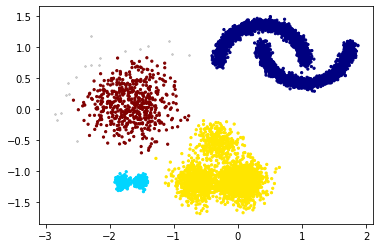

Unique labels (-1 for outliers): [-1  0  1  2  3]


In [4]:
clusterer = HDBSCAN_flat(X,
                         cluster_selection_method='eom',
                         n_clusters=4, min_cluster_size=10)
labels = clusterer.labels_
proba = clusterer.probabilities_

plt.scatter(X[labels>=0, 0], X[labels>=0, 1], c=labels[labels>=0], s=5,
            cmap=plt.cm.jet)
plt.scatter(X[labels<0, 0], X[labels<0, 1], c='k', s=3, marker='x', alpha=0.2)
plt.show()
print(f"Unique labels (-1 for outliers): {np.unique(labels)}")

## Train for more clusters

/home/sabarish/work/hdbscan/hdbscan/flat.py:156: UserWarning: Cannot predict more than 6 with cluster selection method 'eom'. Changing to method 'leaf'...
  warn(f"Cannot predict more than {max_eom_clusters} with cluster "


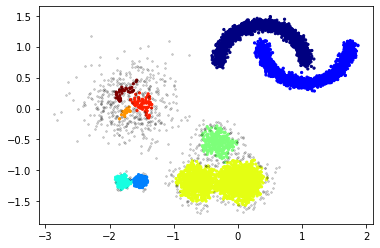

Unique labels (-1 for outliers): [-1  0  1  2  3  4  5  6  7  8]


In [5]:
clusterer = HDBSCAN_flat(X,
                         cluster_selection_method='eom',
                         n_clusters=9, min_cluster_size=10)
labels = clusterer.labels_
proba = clusterer.probabilities_

plt.scatter(X[labels>=0, 0], X[labels>=0, 1], c=labels[labels>=0], s=5,
            cmap=plt.cm.jet)
plt.scatter(X[labels<0, 0], X[labels<0, 1], c='k', s=3, marker='x', alpha=0.2)
plt.show()
print(f"Unique labels (-1 for outliers): {np.unique(labels)}")

Because the cluster-persistence-based selection cannot pick out more than 6 clusters (without changing some of the other HDBSCAN arguments), the selection method is modified to 'leaf'. This selection picks more homogeneous clusters.

## Train once, but extract a lot of clusterings

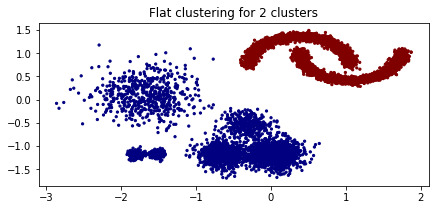

Unique labels (-1 for outliers): [0 1]


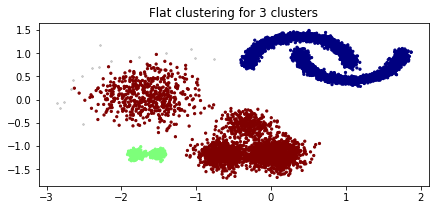

Unique labels (-1 for outliers): [-1  0  1  2]


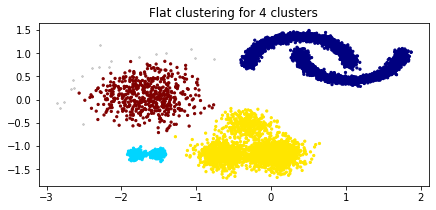

Unique labels (-1 for outliers): [-1  0  1  2  3]


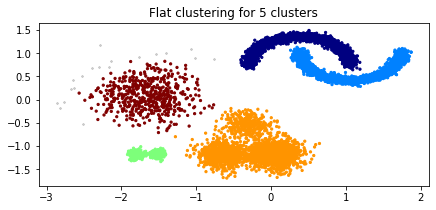

Unique labels (-1 for outliers): [-1  0  1  2  3  4]


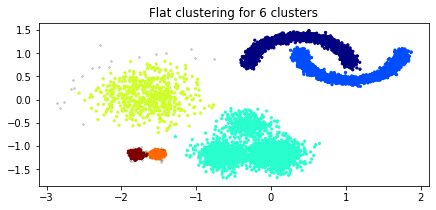

Unique labels (-1 for outliers): [-1  0  1  2  3  4  5]


/home/sabarish/work/hdbscan/hdbscan/flat.py:156: UserWarning: Cannot predict more than 6 with cluster selection method 'eom'. Changing to method 'leaf'...
  warn(f"Cannot predict more than {max_eom_clusters} with cluster "


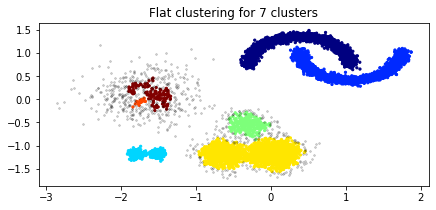

Unique labels (-1 for outliers): [-1  0  1  2  3  4  5  6]


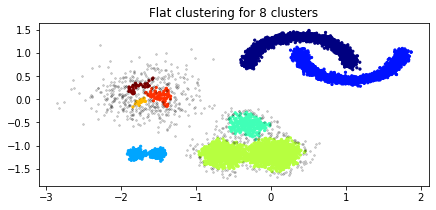

Unique labels (-1 for outliers): [-1  0  1  2  3  4  5  6  7]


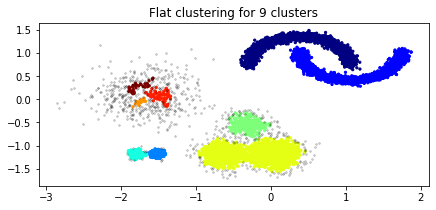

Unique labels (-1 for outliers): [-1  0  1  2  3  4  5  6  7  8]


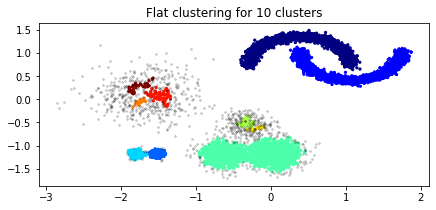

Unique labels (-1 for outliers): [-1  0  1  2  3  4  5  6  7  8  9]


In [6]:
# Train the base HDBSCAN class
clusterer = HDBSCAN(cluster_selection_method='eom', min_cluster_size=10).fit(X)

n_clusters_arr = np.arange(2, 11).astype(int)
for n_clusters in n_clusters_arr:
    clusterer = HDBSCAN_flat(X, clusterer=clusterer,
                             n_clusters=n_clusters)
    # This does not re-train the clusterer;
    #    instead, it extracts flat clustering from the existing hierarchy
    labels = clusterer.labels_
    proba = clusterer.probabilities_

    plt.figure(figsize=(7, 3))
    plt.title(f"Flat clustering for {n_clusters} clusters")
    plt.scatter(X[labels>=0, 0], X[labels>=0, 1], c=labels[labels>=0], s=5,
                cmap=plt.cm.jet)
    plt.scatter(X[labels<0, 0], X[labels<0, 1], c='k', s=3, marker='x', alpha=0.2)
    plt.show()
    print(f"Unique labels (-1 for outliers): {np.unique(labels)}")

# Train with method 'leaf'

to choose homogeneous clusters based on a flat slice of the hierarchy

## Get all clusters larger than 'min_cluster_size'

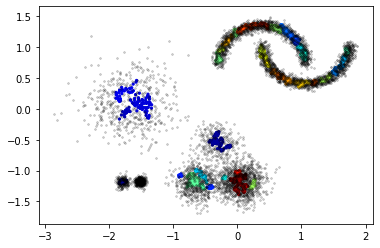

Unique labels (-1 for outliers): [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70
 71 72 73 74]


In [7]:
clusterer = HDBSCAN_flat(X,
                         cluster_selection_method='leaf',
                         n_clusters=None, min_cluster_size=10)
labels = clusterer.labels_
proba = clusterer.probabilities_

plt.scatter(X[labels>=0, 0], X[labels>=0, 1], c=labels[labels>=0], s=5,
            cmap=plt.cm.jet)
plt.scatter(X[labels<0, 0], X[labels<0, 1], c='k', s=3, marker='x', alpha=0.2)
plt.show()
print(f"Unique labels (-1 for outliers): {np.unique(labels)}")

## Or a small number of clusters

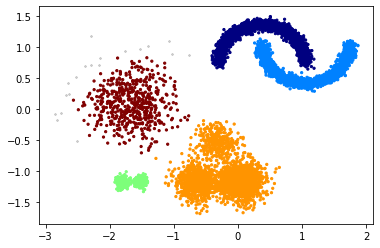

Unique labels (-1 for outliers): [-1  0  1  2  3  4]


In [8]:
clusterer = HDBSCAN_flat(X,
                         cluster_selection_method='leaf',
                         n_clusters=5, min_cluster_size=10)
labels = clusterer.labels_
proba = clusterer.probabilities_

plt.scatter(X[labels>=0, 0], X[labels>=0, 1], c=labels[labels>=0], s=5,
            cmap=plt.cm.jet)
plt.scatter(X[labels<0, 0], X[labels<0, 1], c='k', s=3, marker='x', alpha=0.2)
plt.show()
print(f"Unique labels (-1 for outliers): {np.unique(labels)}")

# Predict for novel points

The function used for prediction is hdbscan.flat.approximate_predict_flat. It works similar to hdbscan.approximate_predict, but also takes 'n_clusters', 'cluster_selection_epsilon', and 'prediction_data' as keyword arguments. Any of these three arguments can specify a flat clustering. See docstring for details.

### Using trained instance with 5 clusters

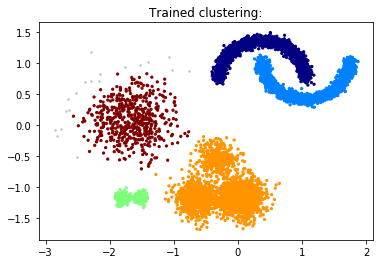

Unique labels (-1 for outliers): [-1  0  1  2  3  4]


In [9]:
clusterer = HDBSCAN_flat(X,
                         cluster_selection_method='eom',
                         n_clusters=5, min_cluster_size=10)
labels = clusterer.labels_
proba = clusterer.probabilities_

plt.title("Trained clustering:")
plt.scatter(X[labels>=0, 0], X[labels>=0, 1], c=labels[labels>=0], s=5,
            cmap=plt.cm.jet)
plt.scatter(X[labels<0, 0], X[labels<0, 1], c='k', s=3, marker='x', alpha=0.2)
plt.show()
print(f"Unique labels (-1 for outliers): {np.unique(labels)}")

## Predict for 9 clusters

/home/sabarish/work/hdbscan/hdbscan/flat.py:307: UserWarning: Cannot predict more than 5 with cluster selection method 'eom'. Changing to method 'leaf'...
  warn(f"Cannot predict more than {n_clusters_fit} with cluster "


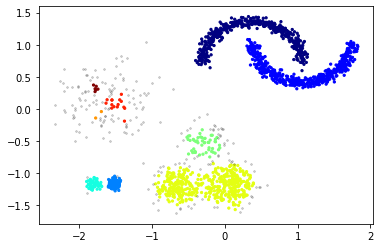

Unique labels (-1 for outliers): [-1  0  1  2  3  4  5  6  7  8]


In [10]:
labels, proba = approximate_predict_flat(clusterer, X_test, n_clusters=9)

plt.scatter(X_test[labels>=0, 0], X_test[labels>=0, 1],
            c=labels[labels>=0], s=5,
            cmap=plt.cm.jet)
plt.scatter(X_test[labels<0, 0], X_test[labels<0, 1],
            c='k', s=3, marker='x', alpha=0.2)
plt.show()
print(f"Unique labels (-1 for outliers): {np.unique(labels)}")

## Predict for 3 clusters

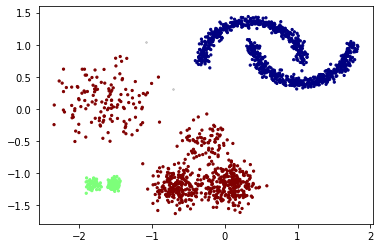

Unique labels (-1 for outliers): [-1  0  1  2]


In [11]:
labels, proba = approximate_predict_flat(clusterer, X_test, n_clusters=3)

plt.scatter(X_test[labels>=0, 0], X_test[labels>=0, 1],
            c=labels[labels>=0], s=5,
            cmap=plt.cm.jet)
plt.scatter(X_test[labels<0, 0], X_test[labels<0, 1],
            c='k', s=3, marker='x', alpha=0.2)
plt.show()
print(f"Unique labels (-1 for outliers): {np.unique(labels)}")

# Cluster labels by membership

The function used for soft-clustering (on training set) is hdbscan.flat.all_points_membership_vectors_flat. It works similar to hdbscan.all_points_membership_vectors, but also takes 'n_clusters', 'cluster_selection_epsilon', and 'prediction_data' as keyword arguments. Any of these three arguments can specify a flat clustering. See docstring for details.


In [12]:
def clusters_from_membership(memberships, threshold=0.2):
    """
    Assign cluster labels by max membership probability,
        and outliers by comparing against some threshold
    """
    labels = np.argmax(memberships, axis=1)
    proba = np.amax(memberships, axis=1)
    labels[proba < threshold] = -1
    return labels, proba

## For training set, at n_clusters used for training

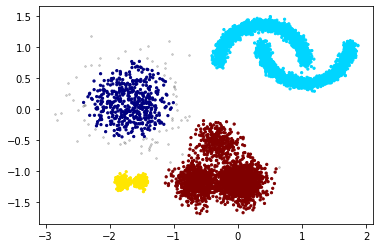

Unique labels (-1 for outliers): [-1  0  1  2  3]


In [13]:
n_clusters = 4
clusterer = HDBSCAN_flat(X,
                         cluster_selection_method='eom',
                         n_clusters=n_clusters, min_cluster_size=10)
memberships = all_points_membership_vectors_flat(clusterer)
labels, proba = clusters_from_membership(memberships)

plt.scatter(X[labels>=0, 0], X[labels>=0, 1], c=labels[labels>=0], s=5,
            cmap=plt.cm.jet)
plt.scatter(X[labels<0, 0], X[labels<0, 1], c='k', s=3, marker='x', alpha=0.2)
plt.show()
print(f"Unique labels (-1 for outliers): {np.unique(labels)}")

## For training set, and different n_clusters

/home/sabarish/work/hdbscan/hdbscan/flat.py:875: UserWarning: Failed to predict 8 clusters with cluster selection method 'eom'. Switching to 'leaf'...
  warn(f"Failed to predict {n_clusters} clusters with "


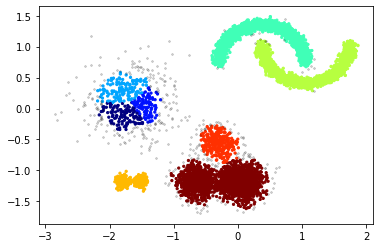

Unique labels (-1 for outliers): [-1  0  1  2  3  4  5  6  7]


In [14]:
n_clusters = 8
memberships = all_points_membership_vectors_flat(clusterer, n_clusters=n_clusters)
labels, proba = clusters_from_membership(memberships)

plt.scatter(X[labels>=0, 0], X[labels>=0, 1], c=labels[labels>=0], s=5,
            cmap=plt.cm.jet)
plt.scatter(X[labels<0, 0], X[labels<0, 1], c='k', s=3, marker='x', alpha=0.2)
plt.show()
print(f"Unique labels (-1 for outliers): {np.unique(labels)}")

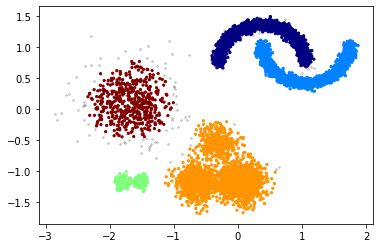

Unique labels (-1 for outliers): [-1  0  1  2  3  4]


In [15]:
n_clusters = 5
memberships = all_points_membership_vectors_flat(clusterer, n_clusters=n_clusters)
labels, proba = clusters_from_membership(memberships)

plt.scatter(X[labels>=0, 0], X[labels>=0, 1], c=labels[labels>=0], s=5,
            cmap=plt.cm.jet)
plt.scatter(X[labels<0, 0], X[labels<0, 1], c='k', s=3, marker='x', alpha=0.2)
plt.show()
print(f"Unique labels (-1 for outliers): {np.unique(labels)}")

### With a large threshold to separate out more outliers

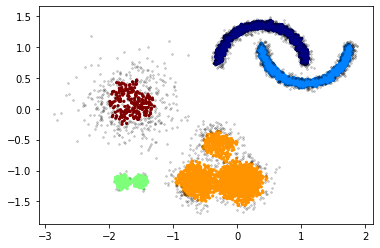

Unique labels (-1 for outliers): [-1  0  1  2  3  4]


In [16]:
n_clusters = 5
threshold = 0.7
memberships = all_points_membership_vectors_flat(clusterer, n_clusters=n_clusters)
labels, proba = clusters_from_membership(memberships, threshold=threshold)

plt.scatter(X[labels>=0, 0], X[labels>=0, 1], c=labels[labels>=0], s=5,
            cmap=plt.cm.jet)
plt.scatter(X[labels<0, 0], X[labels<0, 1], c='k', s=3, marker='x', alpha=0.2)
plt.show()
print(f"Unique labels (-1 for outliers): {np.unique(labels)}")

# Cluster labels by membership, for novel points

The function used for soft-clustering (on novel points) is hdbscan.flat.membership_vector_flat. It works similar to hdbscan.membership_vector, but also takes 'n_clusters', 'cluster_selection_epsilon', and 'prediction_data' as keyword arguments. Any of these three arguments can specify a flat clustering. See docstring for details.


### Train clusterer

In [17]:
n_clusters = None
clusterer = HDBSCAN_flat(X,
                         cluster_selection_method='eom',
                         n_clusters=n_clusters, min_cluster_size=10)

## Predict for different n_clusters

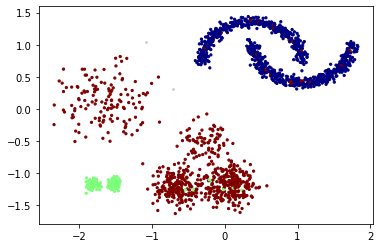

Unique labels (-1 for outliers): [-1  0  1  2]


In [18]:
n_clusters = 3
memberships = membership_vector_flat(clusterer, X_test,
                                     n_clusters=n_clusters)
labels, proba = clusters_from_membership(memberships)

plt.scatter(X_test[labels>=0, 0], X_test[labels>=0, 1],
            c=labels[labels>=0], s=5,
            cmap=plt.cm.jet)
plt.scatter(X_test[labels<0, 0], X_test[labels<0, 1],
            c='k', s=3, marker='x', alpha=0.2)
plt.show()
print(f"Unique labels (-1 for outliers): {np.unique(labels)}")

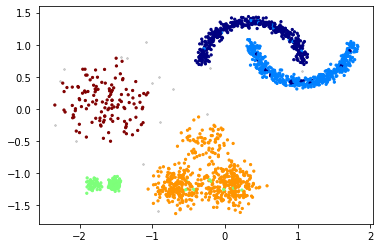

Unique labels (-1 for outliers): [-1  0  1  2  3  4]


In [19]:
n_clusters = 5
memberships = membership_vector_flat(clusterer, X_test,
                                     n_clusters=n_clusters)
labels, proba = clusters_from_membership(memberships)

plt.scatter(X_test[labels>=0, 0], X_test[labels>=0, 1],
            c=labels[labels>=0], s=5,
            cmap=plt.cm.jet)
plt.scatter(X_test[labels<0, 0], X_test[labels<0, 1],
            c='k', s=3, marker='x', alpha=0.2)
plt.show()
print(f"Unique labels (-1 for outliers): {np.unique(labels)}")

/home/sabarish/work/hdbscan/hdbscan/flat.py:729: UserWarning: Failed to predict 8 clusters with cluster selection method 'eom'. Switching to 'leaf'...
  warn(f"Failed to predict {n_clusters} clusters with "


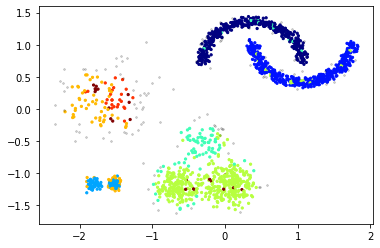

Unique labels (-1 for outliers): [-1  0  1  2  3  4  5  6  7]


In [20]:
n_clusters = 8
memberships = membership_vector_flat(clusterer, X_test,
                                     n_clusters=n_clusters)
labels, proba = clusters_from_membership(memberships)

plt.scatter(X_test[labels>=0, 0], X_test[labels>=0, 1],
            c=labels[labels>=0], s=5,
            cmap=plt.cm.jet)
plt.scatter(X_test[labels<0, 0], X_test[labels<0, 1],
            c='k', s=3, marker='x', alpha=0.2)
plt.show()
print(f"Unique labels (-1 for outliers): {np.unique(labels)}")

Novel prediction on soft-clustered HDBSCAN is a bit dodgy. This apears to be an issue with membership_vector as noted on the GitHub page for HDBSCAN. I'm ignoring this one for now.